# Using a shapefile to generate a network

### Imports
Import the required libraries

In [1]:
import opentnsim
print('This notebook has been tested with OpenTNSim version {}'.format(opentnsim.__version__))

This notebook has been tested with OpenTNSim version 1.1.2


In [2]:
# package(s) related to time, space and id
import datetime
import platform
import random
import os
import pathlib
import warnings

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
import geopandas as gpd

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSIM
import opentnsim.graph_module as graph_module

# Used for making the graph to visualize our problem
import networkx as nx  


from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 


/Users/baart_f/.virtualenvs/opentnsim/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning:

The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [3]:
# Graph location
src_dir = pathlib.Path(opentnsim.__file__).parent.parent
data_path = src_dir / "notebooks" / "Shape-Files"
shape_path = data_path  / "Amsterdam-Canals" / "final_network_v4.shp"


### Create graph

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

# Create a graph from geospatial information
The process to create a graph from a geospatial dataset is the following:

```
dataset -> geopandas dataframe -> project to wgs84 -> networkx
```

This allows you to use all the data formats that geopandas supports. We always use [wgs84](https://en.wikipedia.org/wiki/World_Geodetic_System) to import the graph. That way we can apply our algorithms anywhere in the world. 



## Dataset to geopandas
Let's first convert the data from it's oringal format to geopandas. Geopandas dataframes are tables with a geospatial column. 

In [4]:
# read the file using geopandas
# we need to specify the EPSG code to make sure 

gdf = gpd.read_file(shape_path)
# store length in meters before we convert to degrees
gdf['length_m'] = gdf.geometry.length
print(gdf.crs.name)
gdf.head()

Amersfoort / RD New


,edge_id,cost,width,turnaround,turn_aroun,geometry,length_m
0,0.0,47.952194,50.0,0,NaN,"LINESTRING (122153.226 485731.135, 122138.316 ...",47.952194
1,1.0,30.921218,50.0,0,NaN,"LINESTRING (122138.316 485776.710, 122138.210 ...",30.921218
2,2.0,214.380539,13.0,0,NaN,"LINESTRING (122129.447 485806.332, 121924.805 ...",214.380539
3,3.0,304.623228,13.0,0,NaN,"LINESTRING (121187.522 485724.593, 121152.736 ...",304.623228
4,4.0,575.560869,13.0,0,NaN,"LINESTRING (121758.376 485690.501, 121734.422 ...",575.560869


In [5]:
# this should contain Rijksdriehoek (RD)
gdf_wgs84 = gdf.to_crs('EPSG:4326')
print(gdf_wgs84.crs.name)
gdf.head()

WGS 84


,edge_id,cost,width,turnaround,turn_aroun,geometry,length_m
0,0.0,47.952194,50.0,0,NaN,"LINESTRING (122153.226 485731.135, 122138.316 ...",47.952194
1,1.0,30.921218,50.0,0,NaN,"LINESTRING (122138.316 485776.710, 122138.210 ...",30.921218
2,2.0,214.380539,13.0,0,NaN,"LINESTRING (122129.447 485806.332, 121924.805 ...",214.380539
3,3.0,304.623228,13.0,0,NaN,"LINESTRING (121187.522 485724.593, 121152.736 ...",304.623228
4,4.0,575.560869,13.0,0,NaN,"LINESTRING (121758.376 485690.501, 121734.422 ...",575.560869


## Convert to networkx Graph

In [6]:
FG = graph_module.gdf_to_nx(gdf_wgs84)
# We want an undirected graph for two-way traffic
FG = FG.to_undirected()

In [7]:
assert len(FG.edges) > 0
assert len(FG.nodes) > 0
assert 'geometry' in list(FG.edges.values())[0]
assert 'geometry' in list(FG.nodes.values())[0]

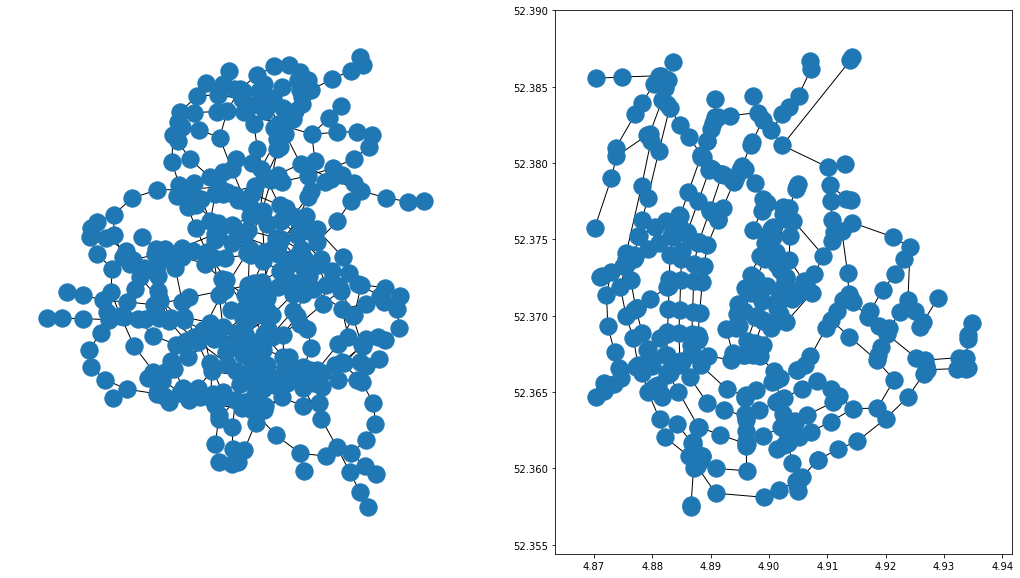

In [8]:
fig, axes = plt.subplots(figsize=(18, 10), ncols=2)
nx.draw(FG, ax=axes[0])
xy = nx.get_node_attributes(FG, 'n')
nx.draw(FG, pos=xy, ax=axes[1])
axes[1].axis('on')
axes[1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

In [9]:
print('The first edge attributes')
print(list(FG.edges.values())[0])
print()
print('The first node attributes')
print(list(FG.nodes.values())[0])


The first edge attributes
{'edge_id': 0.0, 'cost': 47.9521941009, 'width': 50.0, 'turnaround': 0, 'turn_aroun': nan, 'length_m': 47.95219410085968, 'Wkt': 'LINESTRING (4.9050273343119368 52.3584927024455880, 4.9048040135335409 52.3589014100909864)', 'Wkb': b'\x01\x02\x00\x00\x00\x02\x00\x00\x00^lK|\xbf\x9e\x13@\xe2m\xc0\x16\xe3-J@\x16\xaa}\xf1\x84\x9e\x13@\x1fj={\xf0-J@', 'Json': {'type': 'LineString', 'coordinates': ((4.905027334311937, 52.35849270244559), (4.904804013533541, 52.358901410090986))}, 'e': [(4.905027334311937, 52.35849270244559), (4.904804013533541, 52.358901410090986)], 'geometry': <shapely.geometry.linestring.LineString object at 0x17eb63700>}

The first node attributes
{'Wkt': 'POINT (4.9050273343119368 52.3584927024455880)', 'Wkb': b'\x01\x01\x00\x00\x00^lK|\xbf\x9e\x13@\xe2m\xc0\x16\xe3-J@', 'Json': {'type': 'Point', 'coordinates': (4.905027334311937, 52.35849270244559)}, 'n': (4.905027334311937, 52.35849270244559), 'geometry': <shapely.geometry.point.Point object a

# Show on a map
We can also generate a real map. For this we have to step back to pandas, to geopandas and then to ipyleaflet.
``` 
networkx -> pandas -> geopandas -> ipyleaflet
```

In [10]:
df_edges = nx.to_pandas_edgelist(FG)
# generate a geodataframe from the edges, using the Wkt to reconstruct the geometry
gdf_edges = gpd.GeoDataFrame(df_edges, geometry=df_edges['Wkt'].apply(shapely.wkt.loads))
gdf_edges.head()

,source,target,cost,e,Wkt,edge_id,turn_aroun,geometry,width,Wkb,turnaround,Json,length_m
0,"(4.905027334311937, 52.35849270244559)","(4.904804013533541, 52.358901410090986)",47.952194,"[(4.905027334311937, 52.35849270244559), (4.90...",LINESTRING (4.9050273343119368 52.358492702445...,0.0,NaN,"LINESTRING (4.90503 52.35849, 4.90480 52.35890)",50.0,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00^lK|\xbf...,0,"{'type': 'LineString', 'coordinates': ((4.9050...",47.952194
1,"(4.904804013533541, 52.358901410090986)","(4.904670934508645, 52.35916710216342)",30.921218,"[(4.904804013533541, 52.358901410090986), (4.9...",LINESTRING (4.9048040135335409 52.358901410090...,1.0,NaN,"LINESTRING (4.90480 52.35890, 4.90480 52.35890...",50.0,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\x16\xaa...,0,"{'type': 'LineString', 'coordinates': ((4.9048...",30.921218
2,"(4.904670934508645, 52.35916710216342)","(4.9016732144708826, 52.35858070824791)",214.380539,"[(4.904670934508645, 52.35916710216342), (4.90...",LINESTRING (4.9046709345086450 52.359167102163...,2.0,NaN,"LINESTRING (4.90467 52.35917, 4.90167 52.35858)",13.0,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xf1l\xb...,0,"{'type': 'LineString', 'coordinates': ((4.9046...",214.380539
3,"(4.904670934508645, 52.35916710216342)","(4.903965447805071, 52.360340843579266)",139.210726,"[(4.904670934508645, 52.35916710216342), (4.90...",LINESTRING (4.9046709345086450 52.359167102163...,14.0,NaN,"LINESTRING (4.90467 52.35917, 4.90408 52.36011...",50.0,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xf1l\xb...,0,"{'type': 'LineString', 'coordinates': ((4.9046...",139.210726
4,"(4.904670934508645, 52.35916710216342)","(4.905708508467727, 52.35943195740624)",76.578295,"[(4.905708508467727, 52.35943195740624), (4.90...",LINESTRING (4.9057085084677272 52.359431957406...,134.0,NaN,"LINESTRING (4.90571 52.35943, 4.90467 52.35917)",13.0,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xb2O\x1...,0,"{'type': 'LineString', 'coordinates': ((4.9057...",76.578295


In [11]:
import ipyleaflet 
m = ipyleaflet.Map(
    basemap=ipyleaflet.basemap_to_tiles(ipyleaflet.basemaps.OpenStreetMap.Mapnik),
    center=(52.37, 4.90),
    zoom=13
)

style = {'color': 'purple', 'opacity':0.5, 'weight':5}
# show the geometry
geo_data = ipyleaflet.GeoData(geo_dataframe=gdf_edges[['geometry']], style=style)

m.add_layer(geo_data)
m

Map(center=[52.37, 4.9], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…